In [1]:
from LIB.LA.holt_winters import HoltWinters

import numpy as np
import pandas as pd

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True

In [2]:
# read hotel data
df = pd.read_pickle('dataset/preprocessed/4290_imputed.pkl')
# only select final occupancy
df = df[df['LeadTime']==0]
# read hotel data
df['ROH'] = df.ROH/df.TotalCapacity
# timeserise only on ROH
df = df.drop(columns=['LeadTime','DOW','Price','TotalCapacity'])
df = df.set_index('DOA')
# Filling missing values
df = df.asfreq(freq='d', method='ffill')
train = df[:'2019-09-30']
test  = df['2019-09-30':]

<AxesSubplot:>

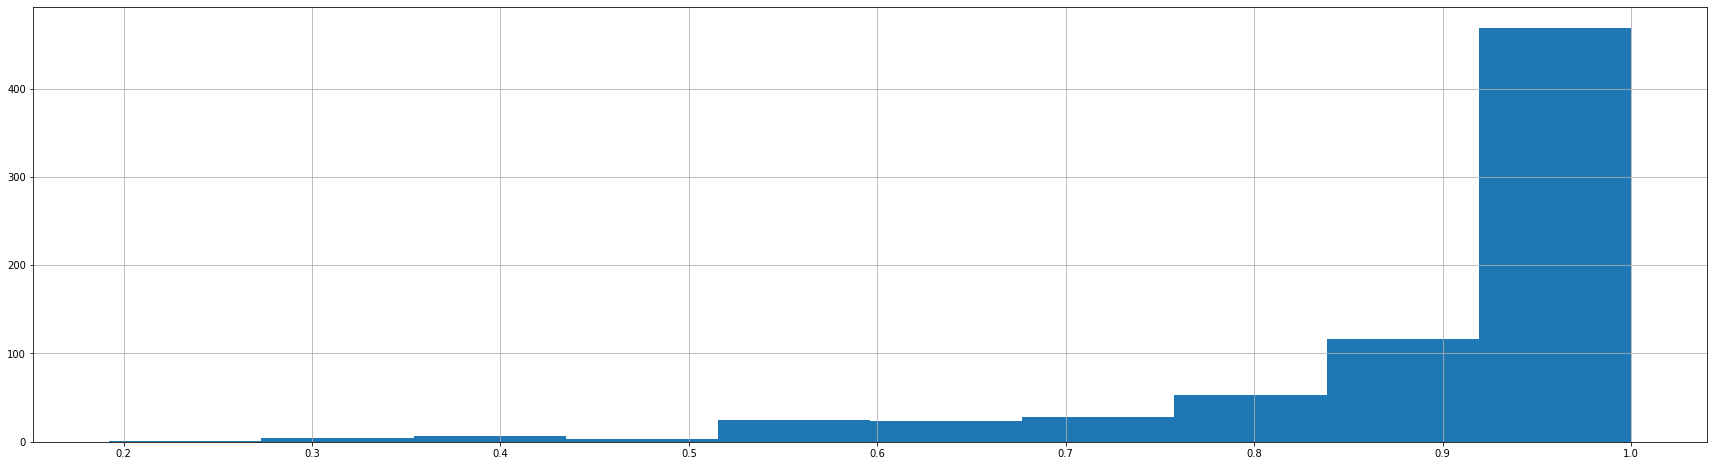

In [3]:
df.ROH.hist()

In [4]:
df.loc[df.ROH<0.5, 'ROH'] = df['ROH'].median()

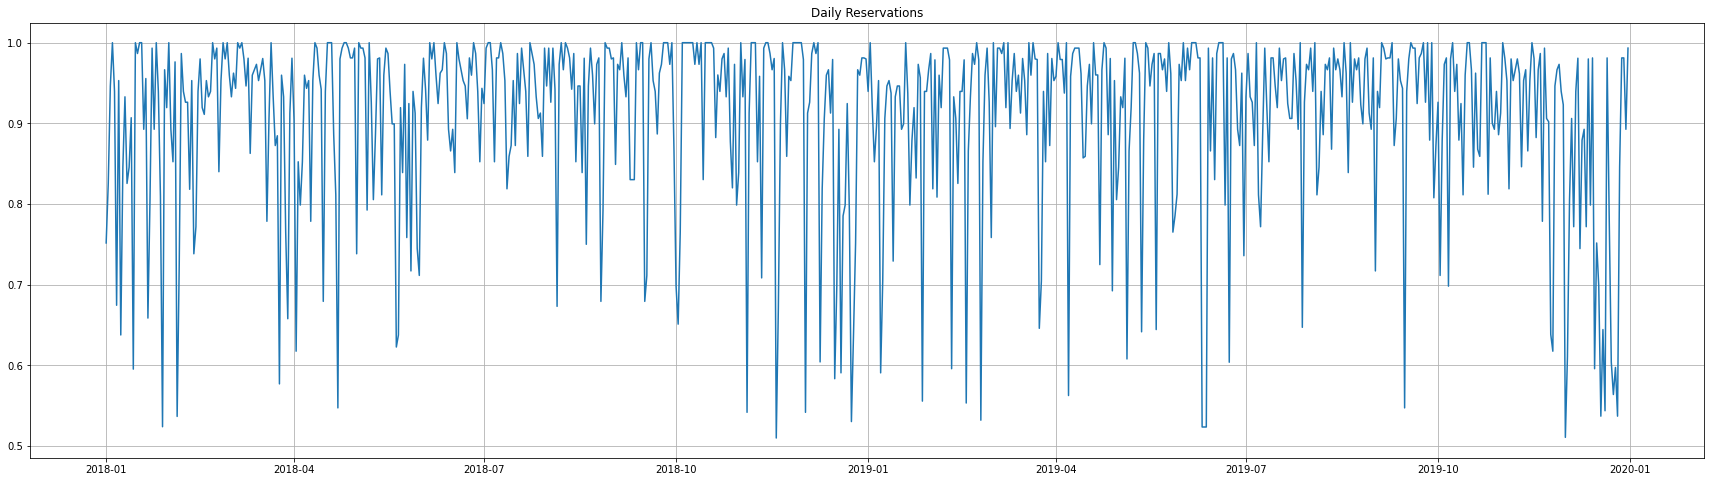

In [5]:
plt.plot(df['ROH'])
plt.title('Daily Reservations')
plt.show()

In [6]:
series = df['ROH']

In [7]:
def initial_trend(series, season_len):
    total = 0.0
    for i in range(season_len):
        total += (series[i + season_len] - series[i]) / season_len

    trend = total / season_len
    return trend


# we have a daily seasonality, which
# means our season length is 24 (the time
# interval in our time series is measured in hours)
season_len = 7
initial_trend(series, season_len)

-0.010225771951626645

In [8]:
# given that we've defined the length for
# our season, we can figure out how many
# seasons are there in our time series
# and we need to compute the average values
# for each season
n_seasons = len(series) // season_len

season_averages = np.zeros(n_seasons)
for j in range(n_seasons):
    start_index = season_len * j
    end_index = start_index + season_len
    season_average = np.sum(series[start_index:end_index]) / season_len
    season_averages[j] = season_average

season_averages

array([0.87007514, 0.79849474, 0.9276124 , 0.8520294 , 0.87766405,
       0.89636538, 0.88758922, 0.94837967, 0.96830623, 0.96613963,
       0.96460061, 0.85021019, 0.87325761, 0.85385047, 0.90087382,
       0.8834277 , 0.9898153 , 0.92738653, 0.91282404, 0.90007055,
       0.8241466 , 0.87875212, 0.95794063, 0.92042186, 0.96177572,
       0.94373994, 0.96776353, 0.92042186, 0.93456828, 0.93863854,
       0.92396194, 0.9794751 , 0.900177  , 0.91888421, 0.94122542,
       0.9490765 , 0.90086651, 0.91899275, 0.9732822 , 0.87344199,
       0.96807106, 0.97652022, 0.93282368, 0.86635107, 0.91882391,
       0.91950069, 0.90104666, 0.93154762, 0.91660674, 0.87517977,
       0.78315454, 0.82970025, 0.93430409, 0.8239054 , 0.93642138,
       0.84496598, 0.91974868, 0.9190755 , 0.86793415, 0.89557537,
       0.91225232, 0.96946207, 0.95501288, 0.92150048, 0.89844528,
       0.91666667, 0.96335109, 0.94255034, 0.89188138, 0.86356974,
       0.91079795, 0.91754554, 0.97437127, 0.89165868, 0.98885

In [9]:
# estimate the initial seasonal components
seasonals = np.zeros(season_len)
seasons = np.arange(n_seasons)
index = seasons * season_len
for i in range(season_len):
    seasonal = np.sum(series[index + i] - season_averages) / n_seasons
    seasonals[i] = seasonal

seasonals

array([-0.02767304,  0.01920465,  0.02197649,  0.03580234,  0.01365415,
        0.04711017, -0.11007477])

In [20]:
def timeseries_cv_score(params, series, loss_function, season_len=24, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

In [37]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 93 points of our time series as test set
x = [0, 0, 0]
test_size = 93
season_len=24
n_splits=3
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error,season_len,n_splits),method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.09489564 0.         0.05141771]


In [38]:
# retrieve optimal values, train the finnal model with them
# and generating forecast for next 93 hours
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=93)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  730
prediction length:  730


In [39]:
test['pred'] = predictions[-93:]

In [40]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'mae': mae, 'mpe': mpe, 'rmse':rmse}) 
res = forecast_accuracy(test['pred'], test['ROH'])
res

{'mape': 0.1533894165704801,
 'mae': 0.10682221254530865,
 'mpe': 0.12221073158553589,
 'rmse': 0.1589284347798065}

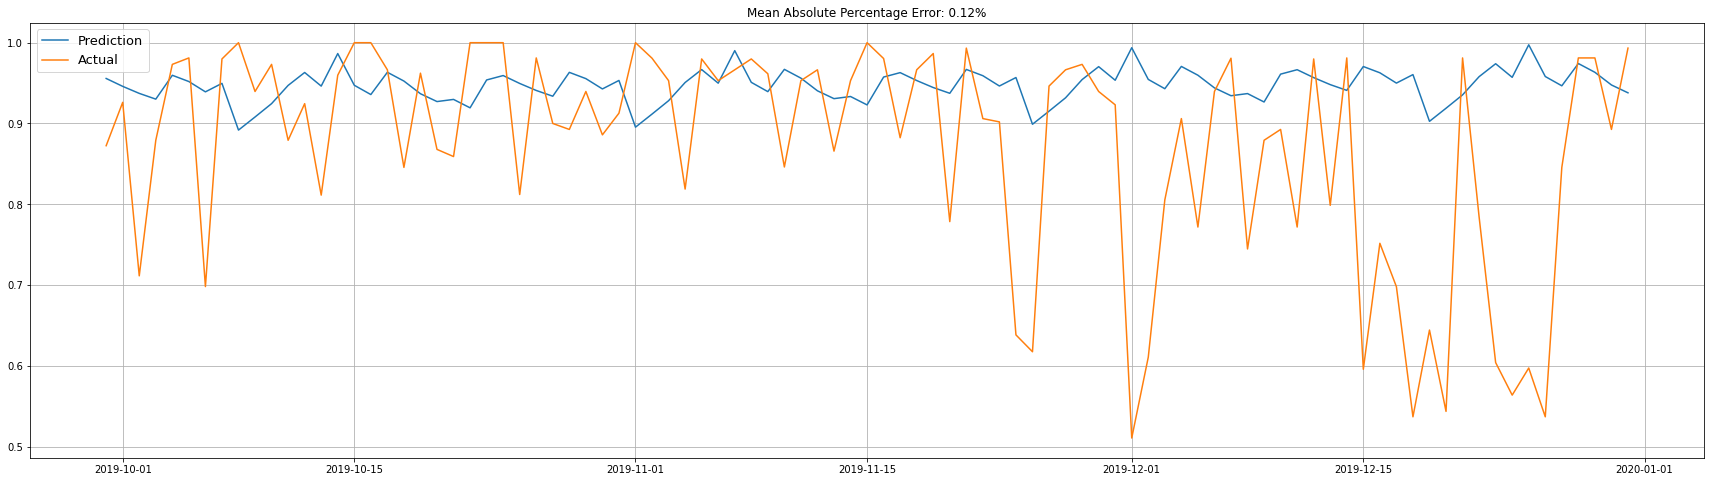

In [41]:
plt.plot(test['pred'], label='Prediction')
plt.plot(test['ROH'], label='Actual')
plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(res['mpe']))
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best', fontsize=13)
plt.show()